In [29]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import os
from classes import *

In [30]:
glass_tube_dir = "Glass Tube"
al_oxide_tube_dir = "Al Oxide Tube"

SLG in Glass Tube

In [31]:
slg_glass = Material('SLG', 'SLG', 'Glass Tube', glass_tube_dir, diameter = 5.6, mass_density=2483)
slg_glass.M = mass_calc(1.72)
slg_glass.M

0.0017695473251028808

[1.0929168e-08 9.4664000e-09 8.3274080e-09 1.1505104e-08]
[143.13255246 123.97558484 109.0589112  150.67522998]


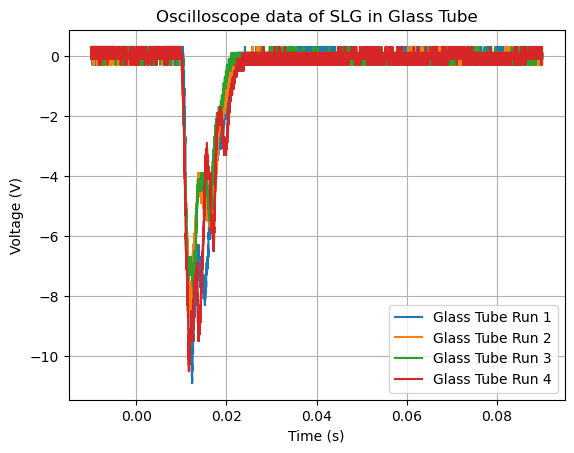

In [32]:
fig, ax = plt.subplots()
slg_glass.plot_ch1(ax)
print(slg_glass.Qs)
print(slg_glass.charge_per_surface_area())


TiO2 in Glass Tube

In [33]:
tio2_glass = Material('TiO2', 'TiO2', 'Glass Tube', glass_tube_dir, diameter = 14.0, mass_density=4.26)
tio2_glass.M = mass_calc(2.04)
tio2_glass.M

0.002098765432098766

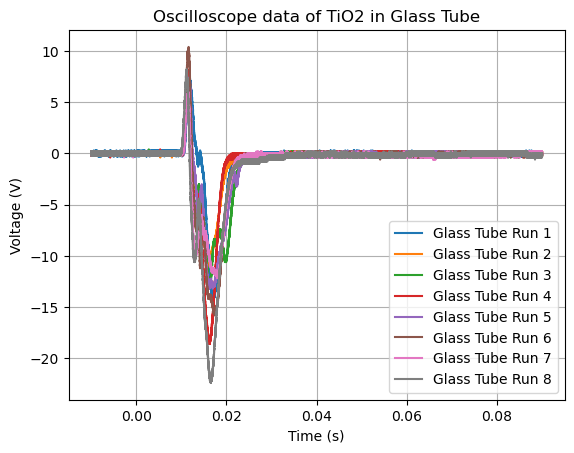

In [34]:
fig, ax = plt.subplots()
tio2_glass.plot_ch1(ax)

In [35]:
print(tio2_glass.Qs)
mean = np.mean(tio2_glass.Qs)
std = np.std(tio2_glass.Qs)
print(mean)
print(std)

[9.8998720e-09 9.4374880e-09 1.4609104e-08 1.3051904e-08 1.4674800e-08
 1.5856848e-08 1.5944160e-08 2.2088688e-08]
1.4445357999999996e-08
3.7151813598278135e-09


In [36]:
print(tio2_glass.charge_per_surface_area())

[0.46886958 0.44697053 0.69190435 0.61815353 0.69501579 0.75099898
 0.75513418 1.04614625]


Al2O3 in Glass tube

al2o3_glass = Material